# **Medical Cost Prediction: Machine Learning Workflow for Regression Tasks**

## Overview
##### This notebook is an step-by-step instruction to train a machine learning model to prediction medical insurance cost based on insrued age, sex, BMI, children, smoking history, and region in the United States. Following topics will be discussed:

##### 1. Python packages requirements
##### 2. Loading data and exploratory data analsys (EDA)
##### 3. Data cleaning and preprocessing
##### 4. Model training and optimization 
##### 5. Model evaluation using key metrics

##### **1. Python packages requirements**

In [90]:
# Loading data
import numpy as np 
import pandas as pd 

# Exploratory data analsys (EDA) 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Data cleaning and preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Model training 
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# Model evaluation 
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

In [91]:
warnings.filterwarnings('ignore')

##### **2. Loading data and exploratory data analsys (EDA)**

In [93]:
"""
# 2. Load data
"""
sudhirln92_csv = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/refs/heads/master/insurance.csv'
try:
    df = pd.read_csv(sudhirln92_csv)
    source = 'https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/README.md'
except Exception:
    repo_csv = '../data/medical_cost_personal_datasets.csv'
    df = pd.read_csv(repo_csv)
    source = 'SWB_Predictive_Analytics_Machine_Leanring raw CSV'

print('Data source:', source)
print('Shape:', df.shape)
df.head()


Data source: https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/README.md
Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [95]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


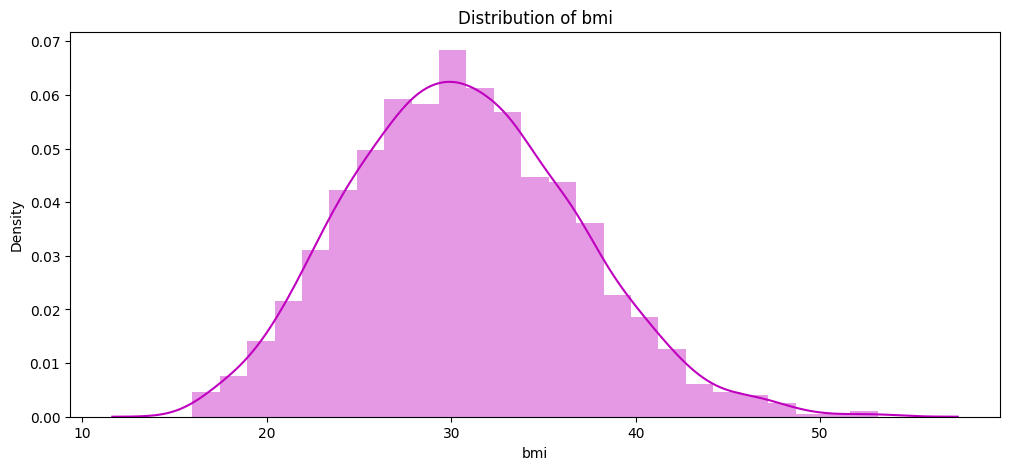

In [96]:
plt.figure(figsize=(12,5))
plt.title("Distribution of bmi")
ax = sns.distplot(df["bmi"], color = 'm')

##### **3. Data cleaning and preprocessing**

In [97]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [98]:
# preprocessing for plotting
#sex
le = LabelEncoder()
le.fit(df.sex.drop_duplicates()) 
df.sex = le.transform(df.sex)
# smoker or not
le.fit(df.smoker.drop_duplicates()) 
df.smoker = le.transform(df.smoker)
#region
le.fit(df.region.drop_duplicates()) 
df.region = le.transform(df.region)

In [99]:
for index, class_label in enumerate(le.classes_):
    print(f"{class_label} -> {index}")

northeast -> 0
northwest -> 1
southeast -> 2
southwest -> 3


In [100]:
df.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

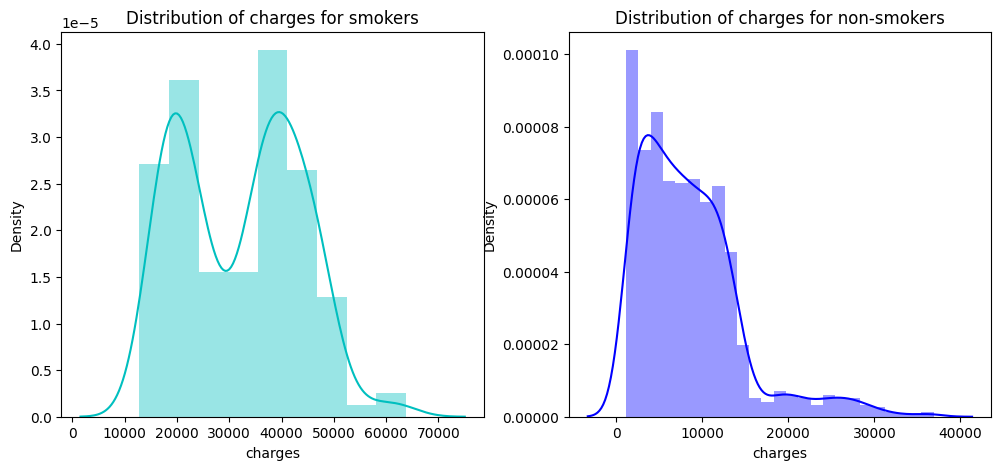

In [101]:
# plotting

f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(df[(df.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(df[(df.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('Distribution of charges for non-smokers')

<Axes: >

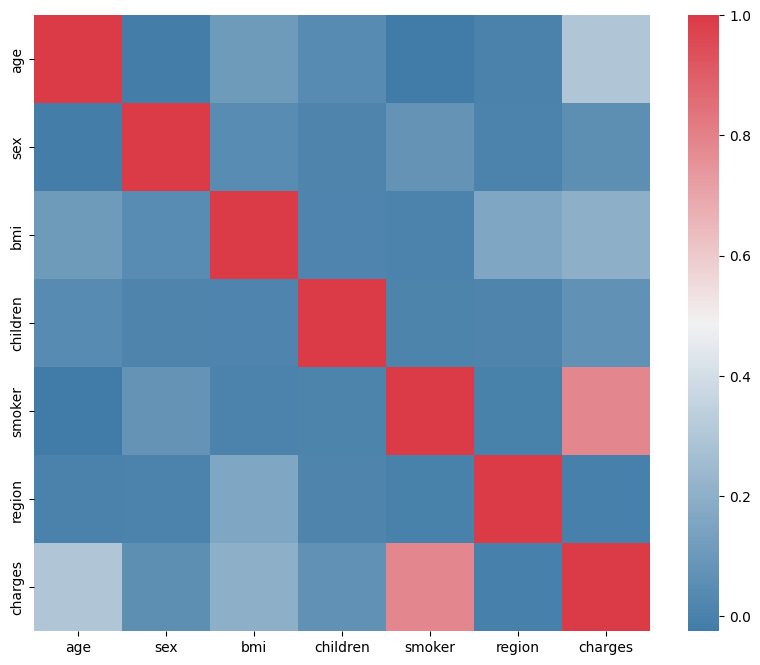

In [102]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

In [103]:
# define X and y columns for regression 
X = df.drop(['charges'], axis = 1)
y = df.charges

# divide X and y into training and testing datasets. 
# The training dataset is used to train/calibrate the model. 
# The test data set is used to test the trained model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# normalize each variable in the X data sets. 
# without normalizatoin, columns with bigger values would dominate the model training. 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### **4. Model training and optimization**

In [104]:
# define metrics that is used to evaluate models' training
scoring = {
    'R2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))
}

# define cross-validation procedure.
# cross-validation technique is used to find optimal modelling parameters and to avoid issues such as overfitting.
# for more information goto: https://scikit-learn.org/stable/modules/cross_validation.html
cv = KFold(n_splits=7, shuffle=True, random_state=99)

# initialize the Linear
lr = LinearRegression()

# cross-validation on training set
cv_scores_lr_r2 = cross_val_score(lr, X_train_scaled, y_train, cv=cv, scoring='r2')
cv_scores_lr_rmse = cross_val_score(lr, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error')
print("Cross-validation R^2 scores:", cv_scores_lr_r2)
print("Mean R^2 score:", np.mean(cv_scores_lr_r2))
print("Cross-validation RMSE:", cv_scores_lr_rmse)
print("Mean RMSE:", np.mean(cv_scores_lr_rmse))

Cross-validation R^2 scores: [0.76575123 0.76134464 0.69211324 0.70794175 0.7504977  0.75256131
 0.77011227]
Mean R^2 score: 0.7429031630131177
Cross-validation RMSE: [-6347.85164085 -6364.61076072 -5995.1522164  -6194.14190546
 -5748.24873955 -6415.22447255 -5703.6685446 ]
Mean RMSE: -6109.84261144779


In [105]:
# Using tree-based algorithm: Random Forest regressor instead of linear regressor
# Define a Random Forest with more hyperparameters
rf = RandomForestRegressor(
    n_estimators=200,            # number of trees
    max_depth=20,                # maximum depth of each tree
    min_samples_split=5,         # minimum samples required to split
    min_samples_leaf=2,          # minimum samples required at a leaf
    max_features='sqrt'         # number of features to consider at each split
)

# cross-validation on training set
cv_scores_rf_r2 = cross_val_score(rf, X_train_scaled, y_train, cv=cv, scoring='r2')
cv_scores_rf_rmse = cross_val_score(rf, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error')
print("Cross-validation R^2 scores:", cv_scores_rf_r2)
print("Mean R^2 score:", np.mean(cv_scores_rf_r2))
print("Cross-validation RMSE:", cv_scores_rf_rmse)
print("Mean RMSE:", np.mean(cv_scores_rf_rmse))

Cross-validation R^2 scores: [0.86569272 0.84673053 0.81089802 0.83597484 0.83739099 0.86281121
 0.86191986]
Mean R^2 score: 0.8459168813645623
Cross-validation RMSE: [-4811.10717241 -5014.13498055 -4722.33358847 -4602.02937226
 -4659.81419095 -4731.99349309 -4340.64753279]
Mean RMSE: -4697.437190073967


In [54]:
# model like Random Forest Regression have a lot of parameters.
# to optimize the parameters we can use algorithms such as GridSearchCV to probe comnbination of various options for each parameter.
# the goal is to find a set of modelling parameters that returns the best scoring (R2, RMSE, ...).

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# define scoring
scoring = {
    'r2': 'r2',
    'rmse': 'neg_root_mean_squared_error'
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    refit='r2',  # Refit the best model based on R²
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Run the grid search
grid_search.fit(X_train_scaled, y_train)

# Show best parameters
print("Best Parameters (based on R²):", grid_search.best_params_)

# Best R² and RMSE scores (CV)
best_index = grid_search.best_index_
cv_results = grid_search.cv_results_

best_r2 = cv_results['mean_test_r2'][best_index]
best_rmse = -cv_results['mean_test_rmse'][best_index]  # Negated back to RMSE

print(f"Best CV R²: {best_r2:.4f}")
print(f"Best CV RMSE: {best_rmse:.4f}")

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test_scaled)

test_r2 = best_model.score(X_test_scaled, y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\nTest R²: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Fitting 7 folds for each of 108 candidates, totalling 756 fits
Best Parameters (based on R²): {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV R²: 0.8488
Best CV RMSE: 4680.0099

Test R²: 0.8351
Test RMSE: 4815.9455


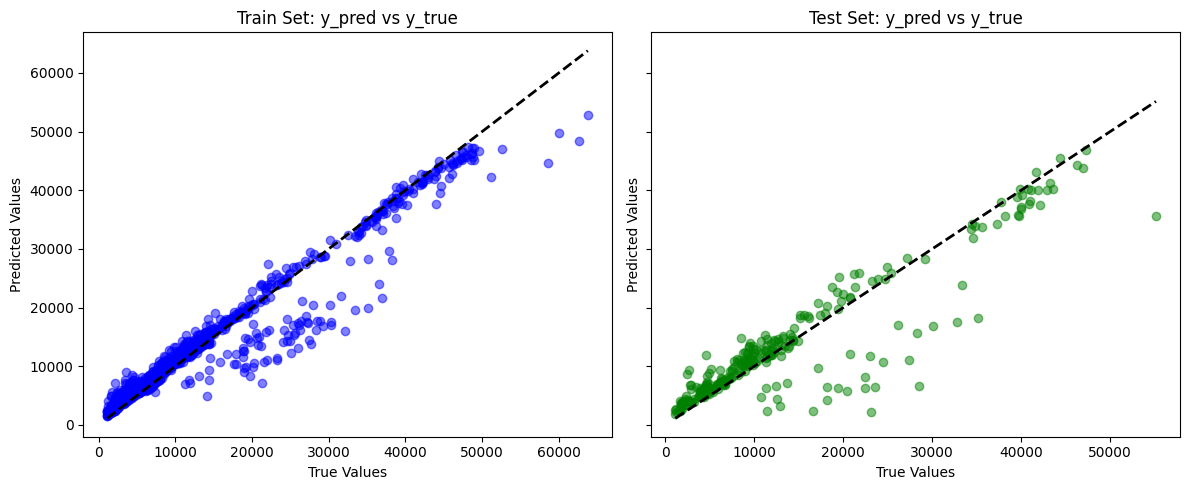

In [55]:
y_pred_train = best_model.predict(X_train_scaled)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Train plot
axs[0].scatter(y_train, y_pred_train, alpha=0.5, color='blue')
axs[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
axs[0].set_title('Train Set: y_pred vs y_true')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predicted Values')

# Test plot
axs[1].scatter(y_test, y_pred_test, alpha=0.5, color='green')
axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axs[1].set_title('Test Set: y_pred vs y_true')
axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [56]:
# use gridsearch with pipeline tool to compare multiple machine learning models
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
        }
    },
    'PLSRegression': {
        'model': PLSRegression(),
        'params': {
            'regressor__n_components': [1, 2, 3, 4, 5, 6]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=1, criterion = 'squared_error'),
        'params': {
            'regressor__n_estimators': [100, 200],
            'regressor__min_samples_split': [2, 4, 6],
            'regressor__min_samples_leaf': [1, 2, 3]
        }
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingRegressor(random_state=42),
        'params': {
            'regressor__learning_rate': [0.01, 0.02, 0.03],
            'regressor__max_iter': [100, 200],
            'regressor__max_depth': [10, 20],
            'regressor__l2_regularization': [0.1, 0.2, 0.5]
        }
    }
}


In [57]:
results = []
best_models = {}

for name, config in models.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', config['model'])
    ])
    
    grid = GridSearchCV(pipeline,
                        param_grid=config['params'],
                        scoring='r2',
                        cv=cv,
                        n_jobs=-1,
                        verbose=0)

    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_models[name] = best_model
    
     # --- Cross-validated training metrics ---
    train_scores = cross_validate(best_model, X_train, y_train, cv=cv, scoring={
        'R2': 'r2',
        'MAE': 'neg_mean_absolute_error',
        'MSE': 'neg_mean_squared_error'
    })

    # Average cross-validated scores
    r2_train = np.mean(train_scores['test_R2'])
    mae_train = -np.mean(train_scores['test_MAE'])
    mse_train = -np.mean(train_scores['test_MSE'])
    rmse_train = np.sqrt(mse_train)

    # --- Test metrics ---
    y_pred_test = best_model.predict(X_test)
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)

    # --- Collect results ---
    results.append({
        'Model': name,
        'Best Params': best_params,
        'Train R2': round(r2_train, 4),
        'Train MAE': round(mae_train, 4),
        'Train RMSE': round(rmse_train, 4),
        'Test R2': round(r2_test, 4),
        'Test MAE': round(mae_test, 4),
        'Test RMSE': round(rmse_test, 4)
    })

Training LinearRegression...
Training PLSRegression...
Training RandomForest...
Training HistGradientBoosting...


##### **5. Model evaluation**

In [18]:
results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
print(results_df.sort_values(by='Test R2', ascending=False).reset_index(drop=True))

                  Model  \
0  HistGradientBoosting   
1          RandomForest   
2      LinearRegression   
3         PLSRegression   

                                                                                                                       Best Params  \
0  {'regressor__l2_regularization': 0.1, 'regressor__learning_rate': 0.02, 'regressor__max_depth': 10, 'regressor__max_iter': 200}   
1                            {'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}   
2                                                                                                                               {}   
3                                                                                                   {'regressor__n_components': 2}   

   Train R2  Train MAE  Train RMSE  Test R2   Test MAE  Test RMSE  
0    0.8589  2468.2859   4543.0631   0.8361  2639.3039  4801.7140  
1    0.8581  2456.2253   4556.9328   0.8310  2743.8441  4

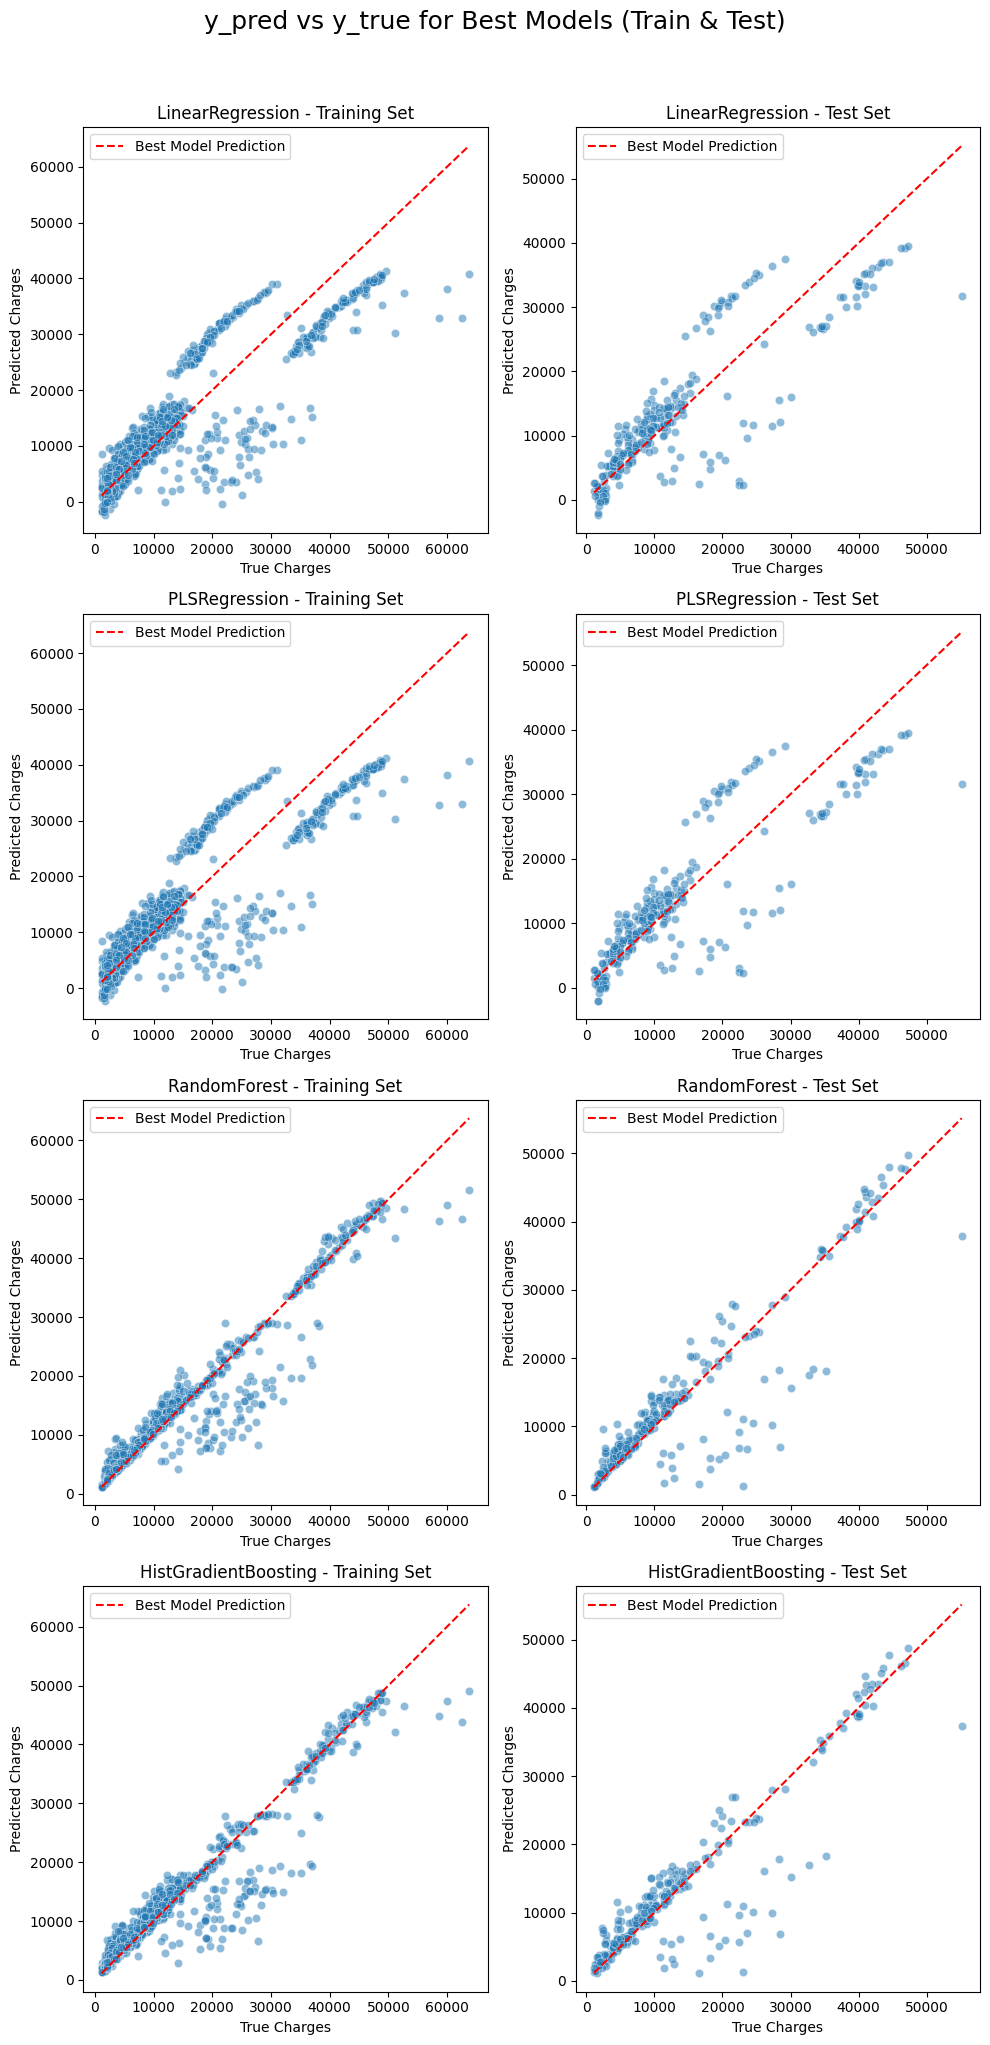

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
axes = axes.flatten()

for i, (name, model) in enumerate(best_models.items()):
    # Train predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # --- Training set plot ---
    ax_train = axes[2 * i]
    sns.scatterplot(x=y_train, y=y_pred_train, ax=ax_train, alpha=0.5)
    ax_train.plot([y_train.min(), y_train.max()],
                  [y_train.min(), y_train.max()],
                  'r--', label='Best Model Prediction')
    ax_train.set_title(f'{name} - Training Set')
    ax_train.set_xlabel('True Charges')
    ax_train.set_ylabel('Predicted Charges')
    ax_train.legend()

    # --- Test set plot ---
    ax_test = axes[2 * i + 1]
    sns.scatterplot(x=y_test, y=y_pred_test, ax=ax_test, alpha=0.5)
    ax_test.plot([y_test.min(), y_test.max()],
                 [y_test.min(), y_test.max()],
                 'r--', label='Best Model Prediction')
    ax_test.set_title(f'{name} - Test Set')
    ax_test.set_xlabel('True Charges')
    ax_test.set_ylabel('Predicted Charges')
    ax_test.legend()

plt.suptitle('y_pred vs y_true for Best Models (Train & Test)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

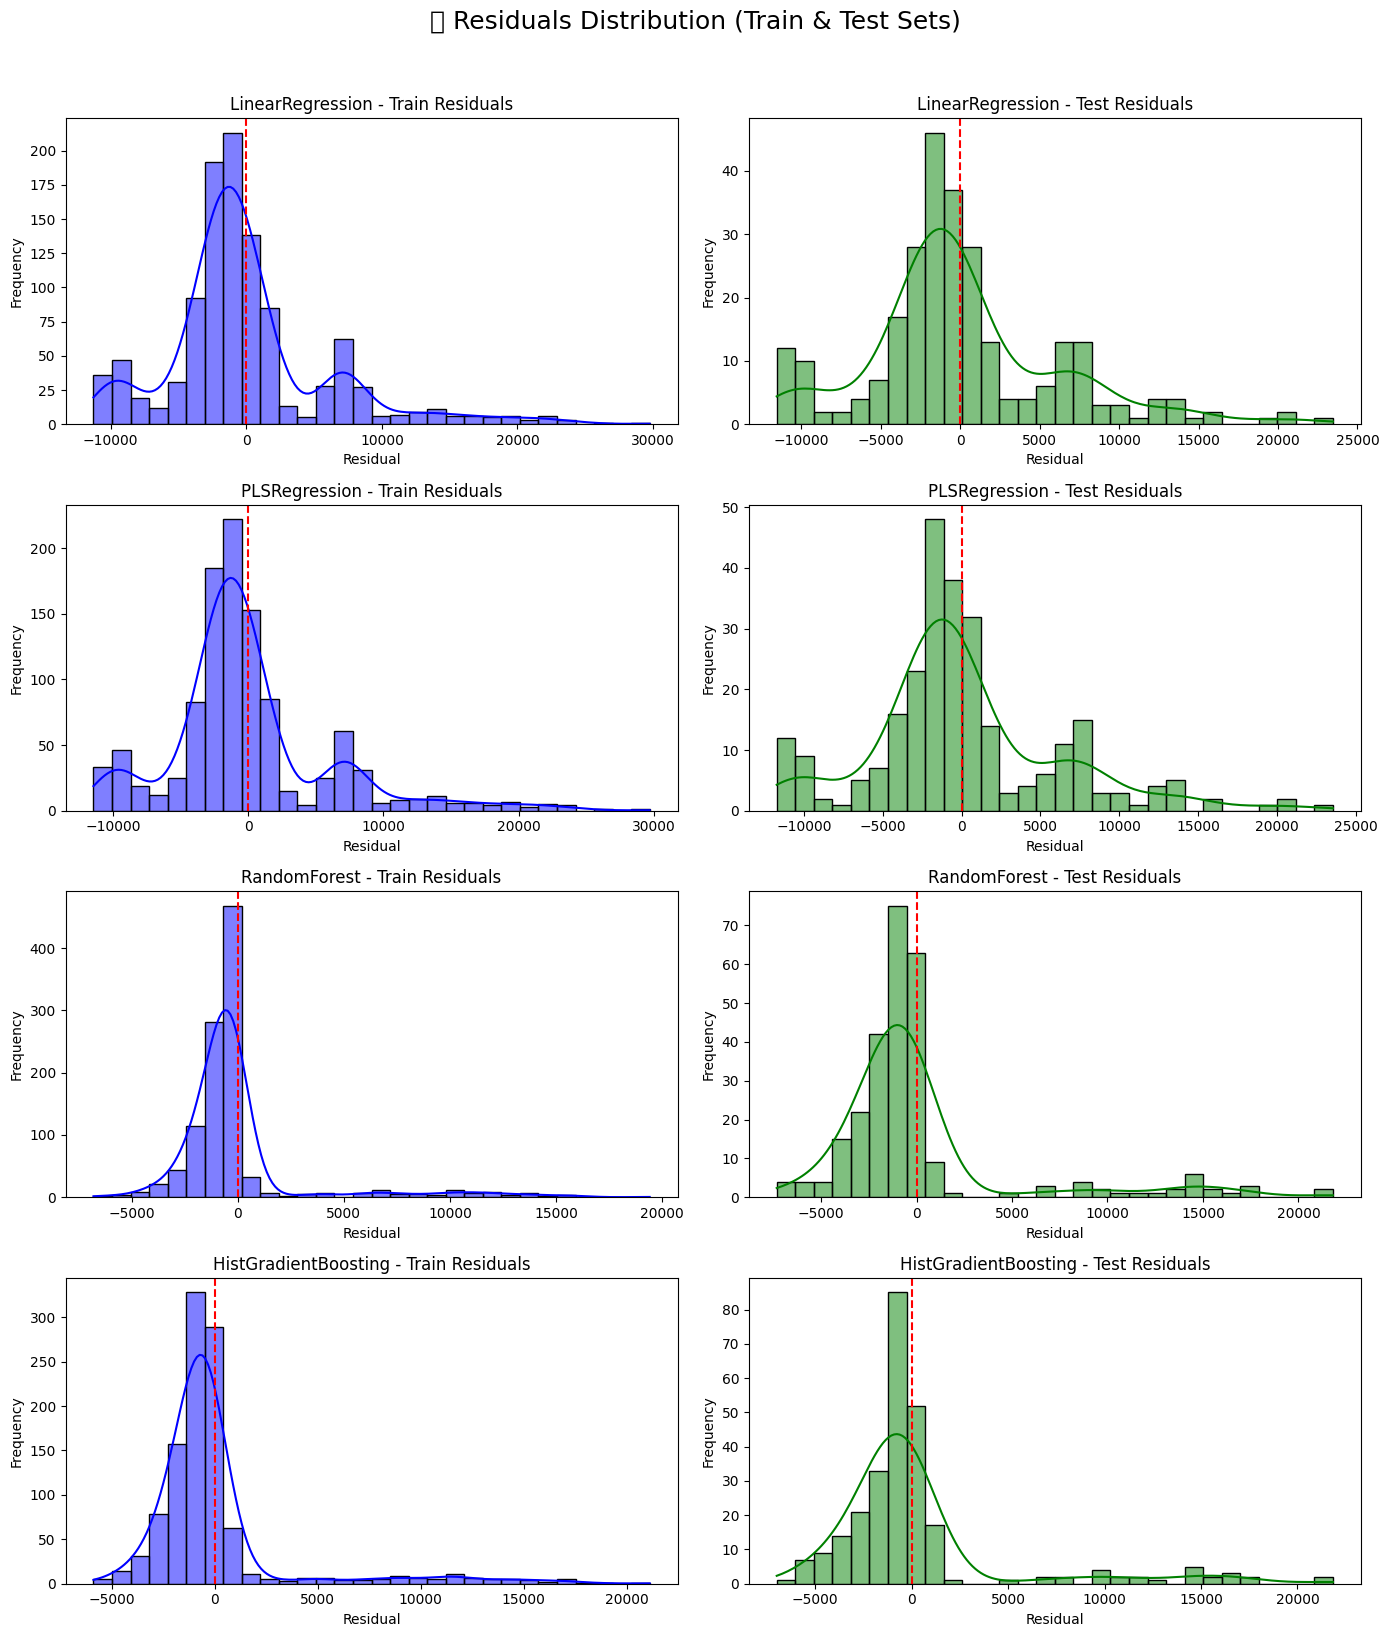

In [20]:
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

for i, (name, model) in enumerate(best_models.items()):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test

    # --- Train residuals distribution ---
    ax_train = axes[2 * i]
    sns.histplot(residuals_train, kde=True, ax=ax_train, color='blue', bins=30)
    ax_train.axvline(0, color='red', linestyle='--')
    ax_train.set_title(f'{name} - Train Residuals')
    ax_train.set_xlabel('Residual')
    ax_train.set_ylabel('Frequency')

    # --- Test residuals distribution ---
    ax_test = axes[2 * i + 1]
    sns.histplot(residuals_test, kde=True, ax=ax_test, color='green', bins=30)
    ax_test.axvline(0, color='red', linestyle='--')
    ax_test.set_title(f'{name} - Test Residuals')
    ax_test.set_xlabel('Residual')
    ax_test.set_ylabel('Frequency')

plt.suptitle('📉 Residuals Distribution (Train & Test Sets)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()